In [44]:
import math

import matplotlib.pyplot as plt
import pandas as pd

from models import Paths

UNMODIFIED_DATA: pd.DataFrame = pd.read_csv(Paths.OHE / "combined-data.csv")


In [45]:
data = UNMODIFIED_DATA.groupby("Year", as_index=False).mean()


In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

data.Temperature.diff().describe()


count    51.000000
mean      0.023252
std       0.202570
min      -0.398136
25%      -0.136318
50%       0.054924
75%       0.162091
max       0.468932
Name: Temperature, dtype: float64

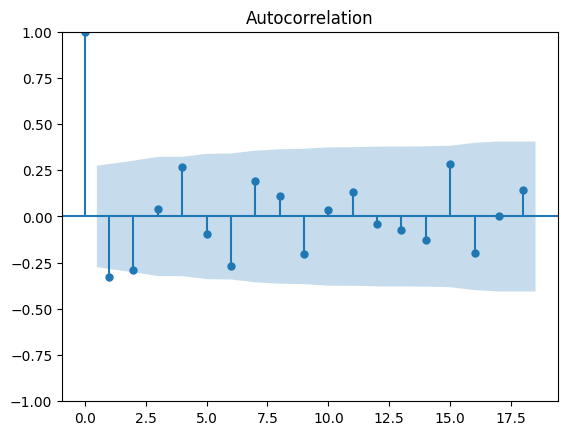

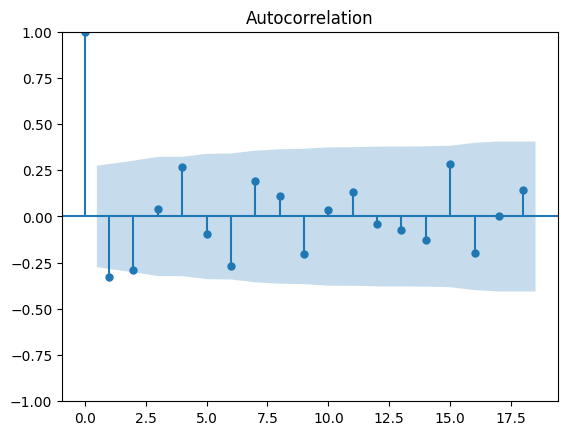

In [47]:
plot_acf(data.Temperature.diff().dropna())


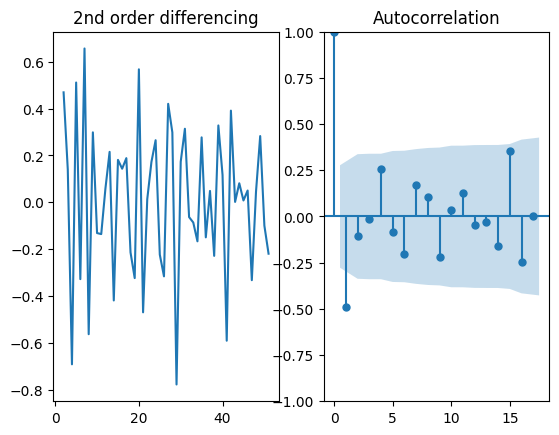

In [48]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(data.Temperature.diff().diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(data.Temperature.diff().diff().dropna(), ax=ax2)

plt.show()


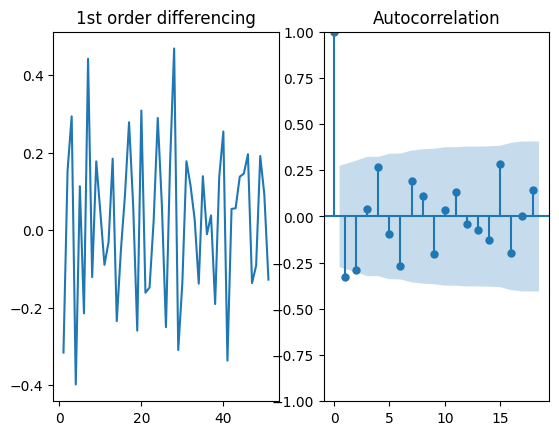

In [49]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(data.Temperature.diff().dropna())

ax2 = f.add_subplot(122)
plot_acf(data.Temperature.diff().dropna(), ax=ax2)

plt.show()


In [50]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data.Temperature)
print("p-value: ".ljust(20), result[1])

result = adfuller(data.Temperature.diff().dropna())
print("1st diff p-value: ".ljust(20), result[1])

result = adfuller(data.Temperature.diff().diff().dropna())
print("2nd diff p-value: ".ljust(20), result[1])


p-value:             0.978613659739638
1st diff p-value:    1.4756444943196828e-11
2nd diff p-value:    8.988537979790679e-05


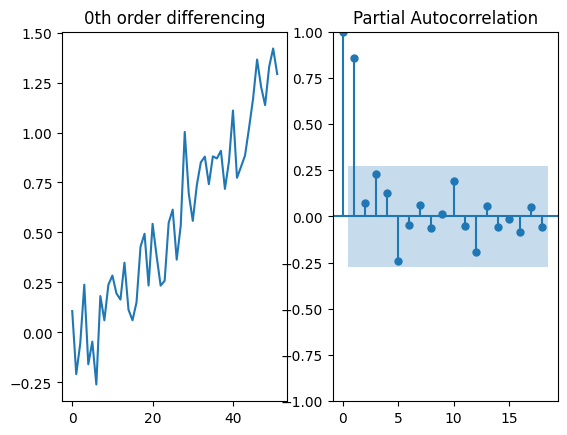

In [51]:
# 1st difference is beyond the 0.05 test threshold, so that is our d value
# d = 1

f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('0th order differencing')
ax1.plot(data.Temperature)

ax2 = f.add_subplot(122)
plot_pacf(data.Temperature, ax=ax2)

plt.show()


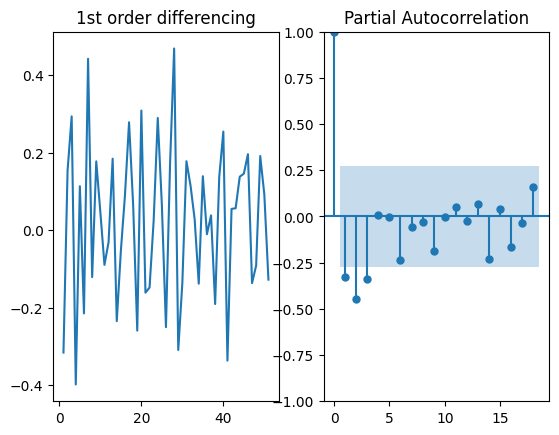

In [52]:
f = plt.figure()
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(data.Temperature.diff().dropna())

ax2 = f.add_subplot(122)
plot_pacf(data.Temperature.diff().dropna(), ax=ax2)

plt.show()


In [53]:
# 1st bar is most significant in both autocorrelations, so we set p = 1

# We use the formula ARIMA(p = 1, d=1, q=2)

In [54]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, shuffle=False, test_size=0.3)

arima_model = ARIMA(train_data.Temperature, order=(1, 1, 2), exog=train_data.Co2)
model = arima_model.fit()
print(model.summary())
# train_data.head()


                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                   36
Model:                 ARIMA(1, 1, 2)   Log Likelihood                  15.271
Date:                Wed, 20 Mar 2024   AIC                            -20.542
Time:                        21:06:16   BIC                            -12.765
Sample:                             0   HQIC                           -17.857
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Co2            0.0214      0.003      6.191      0.000       0.015       0.028
ar.L1         -0.9009      0.284     -3.167      0.002      -1.458      -0.343
ma.L1         -0.0022   2246.505  -9.91e-07      1.0

C:\Users\darra\Projects\pycharm\e3\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


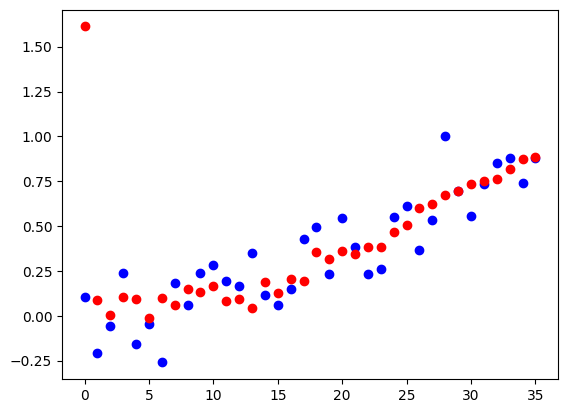

In [55]:
p = model.predict()

# p.head()
# print(p.tolist())
# plt.scatter(data.Year-1970, data.Temperature, color="blue")
plt.scatter(train_data.Year - 1970, train_data.Temperature, color="blue")
plt.scatter(p.index, p.tolist(), color="red")
# plt.show()

# plt.plot(model.simulate(20000, anchor=49))

plt.show()


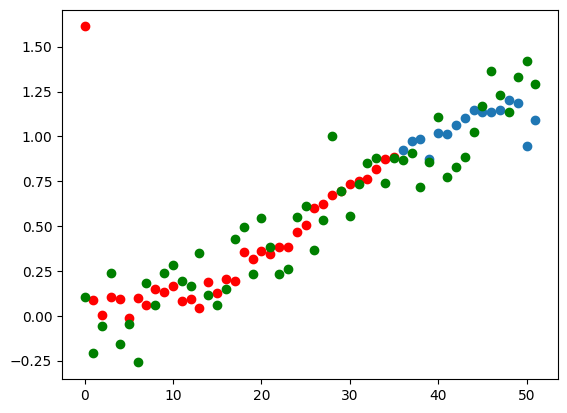

In [56]:
forecast = model.forecast(steps=len(test_data), exog=test_data.Co2)

# Plot the forecasted / test data
plt.scatter(forecast.index, forecast)

# plot the previously trained data as interpreted by the model
plt.scatter(p.index, p.tolist(), color="red")

plt.scatter(data.Year - 1970, data.Temperature, color="green")

plt.show()


In [57]:
# Determine the accuracy of the future predictions based on the actual data we have for the future

from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt

rmse = sqrt(mean_squared_error(test_data.Temperature, forecast))
r2 = r2_score(test_data.Temperature, forecast)

print("RMSE of forecast: ".ljust(20), rmse)
print("R2 of forecast: ".ljust(20), r2)


RMSE of forecast:    0.19575171882489392
R2 of forecast:      0.21729988076954743


In [58]:
data = UNMODIFIED_DATA
cc = [c for c in data.columns if c.startswith("Country_")]

maxdg = -math.inf
mindg = +math.inf
maxdc = None
mindc = None

for c in cc:
    q = f"`{c}` == 1"
    entries = data.query(q)

    diffs = entries

    maxd = max(diffs.Co2)
    mind = min(diffs.Co2)
    if maxd > maxdg:
        maxdg = maxd
        maxdc = c
    if mind < mindg:
        mindg = mind
        mindc = c

print(maxdc, mindc)
print(maxdg, mindg)


Country_United States Country_Anguilla
6004.362376 0.002108963


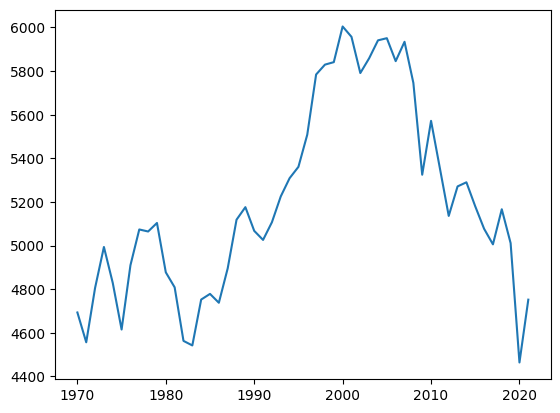

In [59]:
data = data.query("`Country_United States` == 1").dropna()

plt.plot(data.Year, data.Co2)

plt.show()


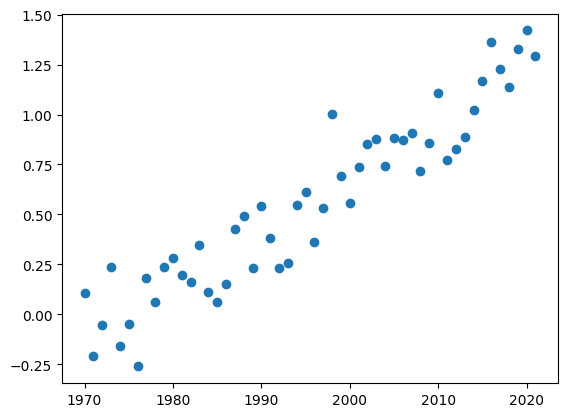

In [60]:
data = UNMODIFIED_DATA.groupby("Year", as_index=False).mean()

plt.scatter(data.Year, data.Temperature)

plt.show()
